In [499]:
import numpy as np
import matplotlib.pyplot as plt
import numba 
from numba import prange

from Single_Var_QR import SingleQRSampler_T_4_block
from Single_Var_QR_utils import geometric_seq


In [500]:
from typing import Union

In [501]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [502]:
%autoreload 2

# Generate some fake data

In [503]:
np.random.seed(8)

In [504]:
x_vals = np.concatenate([np.arange(-0.99,1, 0.01),
                         np.arange(-0.99,1, 0.01),
                        np.arange(-0.99,1, 0.01)])


In [505]:
from scipy.stats import norm

In [506]:
# Generate surya dataset
n_data = 1000
x_vals = np.random.uniform(-1,1,n_data)

def test_beta_0(tau):
    return 3*(tau - 0.5)*(np.log(1/(tau*(1-tau))))

def test_beta_1(tau):
    return 4*((tau-0.5)**2) * (np.log(1/(tau*(1-tau))))

def test_quantile_function_surya(tau, x):
    
    output = 3*(tau - 0.5)*(np.log(1/(tau*(1-tau)))) + 4*((tau-0.5)**2) * (np.log(1/(tau*(1-tau)))) * x

    return output



# Sample 1000 random quantiles
tau_rands = np.random.uniform(0,1,n_data)
y_vals_true = np.array([test_quantile_function_surya(tau, x) for tau, x in zip(tau_rands, x_vals)])
#y_vals_true = np.array([test_quantile_function_simple(tau, x) for tau, x in zip(tau_rands, x_vals)])


## First Plot: Single sample for multiple tau

In [507]:
# Example X_vals and tau_vals
tau_vals = np.arange(0,1,0.05)[1:]

- Use surya data 2017

In [508]:
tau_test = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
beta_0s = [test_beta_0(t) for t in tau_test]
beta_1s = [test_beta_1(t) for t in tau_test]

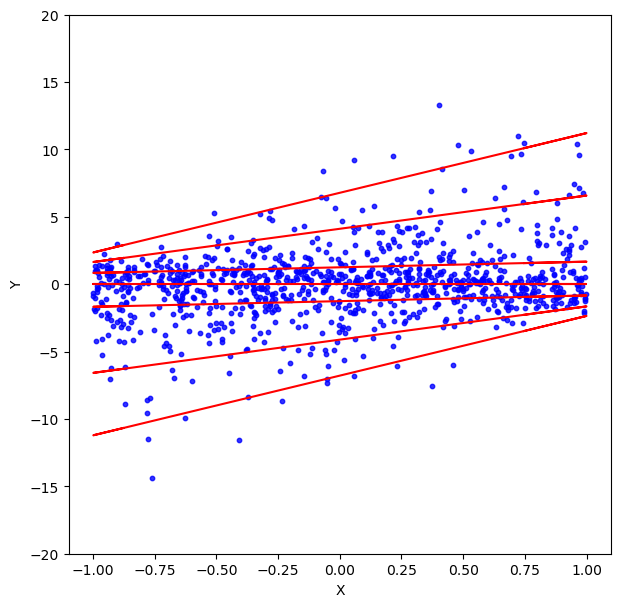

In [566]:
fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(x_vals, y_vals_true, s=10, color='blue', alpha=0.8)
    
    
for b0,b1 in zip(beta_0s, beta_1s):
    
    y_pred_true = b0 + x_vals*b1
    
    ax.plot(x_vals, y_pred_true, c='red')
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_ylim([-20,20])
plt.savefig('Images/QR_data.png')

# MCMC Sampling

- Block (Metropolis in Gibbs):
- Block 1: Eta Function components, GP, lambda and rho
- Block 2: Remaining, mu, gamma, sigma1 and sigma2

# MCMC Sampling Loop with Approximation

Setting priors for 
- W $\sim$ GP Thingy (Just draw from multviariate)?
- $\kappa^2 \sim  IG(3,1/3)$
- $\lambda^2 \sim Ga(5,1/10)$
- $\rho \sim Unif(0,1)$
- $\sigma_1, \sigma_2 \sim Ga(2,2)$
- $\mu \sim N(0,1)$
- $\gamma \sim N(0,1)$

Block metropolis with blocks
- W, $\kappa^2$, $\lambda^2$, $\rho$
-  $\sigma_1, \sigma_2, \mu, \gamma$

Step Size Checker

In [510]:
fig, ax = plt.subplots(figsize=(10,10))
C_1_list = [0.1,0.5]
alpha_step_size_list = [0.1,0.5,0.8]

for C_1 in C_1_list:
    for alpha_step_size_1 in alpha_step_size_list:
        n_steps = 20000
        plot_vals = C_1/(np.arange(1,n_steps+10)**alpha_step_size_1)
        
        ax.plot(np.arange(1,n_steps+10),plot_vals, label=f'C={C_1} , alpha={alpha_step_size_1}')

ax.legend()

4 Block T-mixture

In [511]:
# C = 0.1, alpha = 0.3
n_chains = 2
tau_grid_expanded = np.array([round(-0.01 + 0.01 * i,2) for i in range(103)])
tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])

data_size = n_data
tau_upper_tail = 1-1/(2*data_size)
tau_lower_tail = 1/(2*data_size)
lower_seq = np.flip(geometric_seq(0.01, tau_lower_tail, 0.005, upper=False))
upper_seq = geometric_seq(0.99, tau_upper_tail, 0.005)

tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
tau_grid = np.concatenate([lower_seq, tau_grid, upper_seq])

tau_grid_expanded = np.concatenate([np.array([-0.01,0]),
                                    tau_grid,
                                    np.array([1,1.01])])

knot_points_grid = np.arange(0.1,1,0.1)


In [512]:

sampler_collecter_4blockt = [SingleQRSampler_T_4_block(y_vals_true,
                                    x_vals,          
                                    C_1 = 0.3,
                                    lambda_step_size_1 = 3,
                                    alpha_step_size_1 = 0.4,
                                    a_target_1 = 0.234,
                                    C_2 = 0.3,
                                    lambda_step_size_2 = 3,
                                    alpha_step_size_2 = 0.4,
                                    a_target_2 = 0.234,
                                    C_3 = 0.5,
                                    lambda_step_size_3 = 3,
                                    alpha_step_size_3 = 0.4,
                                    a_target_3 = 0.234,
                                    C_4 = 0.3,
                                    lambda_step_size_4 = 3,
                                    alpha_step_size_4 = 0.4,
                                    a_target_4 = 0.234,
                                    tau_grid_expanded = tau_grid_expanded,
                                    tau_grid = tau_grid,     
                                    knot_points_grid = knot_points_grid,
                                    am_lamb_block1_init = (2.38**2)/(9),
                                    am_lamb_block2_init = (2.38**2)/(9),
                                    am_lamb_block3_init = (2.38**2)/4,
                                    am_lamb_block4_init = (2.38**2)/(9*2+4),
                                    alpha_kappa = 0.1,
                                    beta_kappa = 0.1,
                                    eps_1 = 0,
                                    eps_2 = 0,
                                    base_quantile_mean=0.0,
                                    base_quantile_sd=1.0,
                                    base_quantile_v=1.0,
                                    base_quantile_dist='t',
                                    splice=True) for _ in range(n_chains)]

chain_outputs = [sampler_c.sample(n_steps=20000) for sampler_c in sampler_collecter_4blockt]

sampler_collecter = sampler_collecter_4blockt

Lambda Current:  4
Mu Current:  0
Gamma Current:  0
Sigma 1 Current:  1
Sigma 2 Current:  1
Step:  1000  Time Taken:  13.021836757659912 Block 1 Accept:  33.65853658536585  Block 2 Accept:  15.151515151515152  Block 3 Accept:  5.154639175257732  Block 4 Accept:  33.73253493013972  Sampled Prop:  [0.205 0.198 0.097 0.501]
Lambda Current:  4
Mu Current:  0.27183250800575137
Gamma Current:  0.15644619823089734
Sigma 1 Current:  0.7799652595057415
Sigma 2 Current:  1.201762277608558
Step:  2000  Time Taken:  10.859853982925415 Block 1 Accept:  29.67581047381546  Block 2 Accept:  24.407582938388625  Block 3 Accept:  14.130434782608695  Block 4 Accept:  27.06237424547284  Sampled Prop:  [0.2005 0.211  0.092  0.497 ]
Lambda Current:  4
Mu Current:  -0.1345916953840977
Gamma Current:  -0.06890471625212605
Sigma 1 Current:  0.8071330412699235
Sigma 2 Current:  1.116817409458029
Step:  3000  Time Taken:  11.307278633117676 Block 1 Accept:  26.029654036243823  Block 2 Accept:  26.43312101910828  

# Chain Eval

## Kappa and Lambda

In [513]:
color_scheme = ['tab:blue','tab:red', 'tab:green','tab:orange']

## Mu Gamma Sigmas

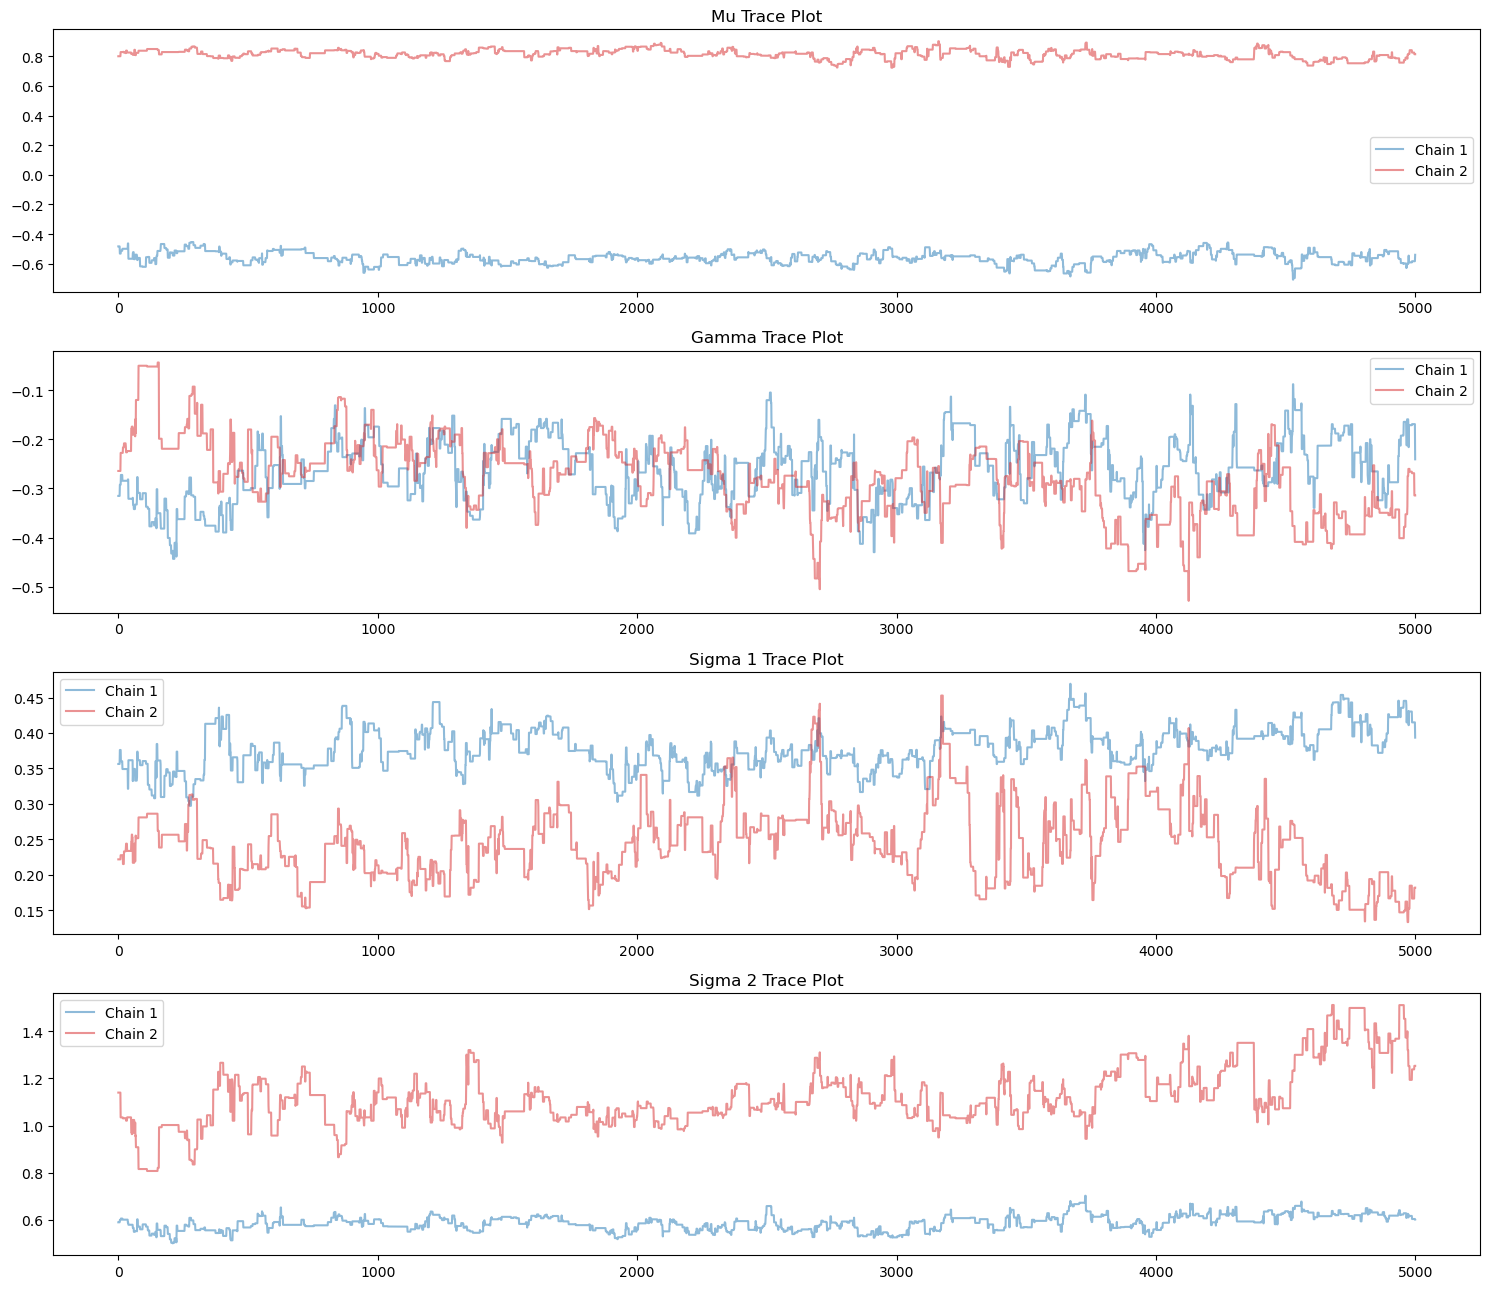

In [514]:
fig, ax = plt.subplots(4,1,figsize=(15,13))
n_burn_in = 15000

for i in range(n_chains):
    ax[0].plot(chain_outputs[i]['mu'][n_burn_in:], alpha=0.5, c=color_scheme[i], label=f'Chain {i+1}')
    ax[1].plot(chain_outputs[i]['gamma'][n_burn_in:], alpha=0.5, c=color_scheme[i], label=f'Chain {i+1}')
    ax[2].plot(chain_outputs[i]['sigma_1'][n_burn_in:], alpha=0.5, c=color_scheme[i], label=f'Chain {i+1}')
    ax[3].plot(chain_outputs[i]['sigma_2'][n_burn_in:], alpha=0.5, c=color_scheme[i], label=f'Chain {i+1}')

ax[0].set_title('Mu Trace Plot')
ax[1].set_title('Gamma Trace Plot')
ax[2].set_title('Sigma 1 Trace Plot')
ax[3].set_title('Sigma 2 Trace Plot')

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

plt.tight_layout()

## Checking Correlation Between Parameters

In [515]:
fig, ax = plt.subplots(2,3, figsize=(15,10))

# mu gamma
for i in range(n_chains):
    
    gamma_samps = chain_outputs[i]['gamma'][n_burn_in:]
    mu_samps = chain_outputs[i]['mu'][n_burn_in:]
    
    ax[0,i].scatter(gamma_samps, mu_samps, s=1)
    
# sigma-sigma
for i in range(n_chains):
    
    sigma_1_samps = chain_outputs[i]['sigma_1'][n_burn_in:]
    sigma_2_samps = chain_outputs[i]['sigma_2'][n_burn_in:]
    
    ax[1,i].scatter(sigma_1_samps, sigma_2_samps, s=1)
    

## Inferred Beta 0 Beta 1 at various tau levels

In [516]:
from typing import List
from Single_Var_QR_utils import *


In [517]:
chain_outputs[i]['w'][0].shape[0]/2

113.0

In [518]:
def generate_beta_samples(tau_input: float,
                          tau_grid: np.ndarray,
                          w_approx_store: List[np.ndarray],
                          mu_store: List[float],
                          gamma_store: List[float],
                          sigma_1_store: List[float],
                          sigma_2_store: List[float]):

    beta_0_store = []
    beta_1_store = []
    for i in range(0,len(w_approx_store)):
        w_samp = w_approx_store[i]
        L = int(w_samp.shape[0]/2)
        w1_samp = w_samp[0:L]
        w2_samp = w_samp[L:]

        mu_samp = mu_store[i]
        gamma_samp = gamma_store[i]
        sigma_1_samp = sigma_1_store[i]
        sigma_2_samp = sigma_2_store[i]


        eta_1_samp = eta_function_i_vector(tau_input=np.array([tau_input]),
                                             w_vals=w1_samp,
                                             tau_grid=tau_grid,
                                             mean=0.0,
                                             sd=1.0,
                                             v=1.0,
                                             sigma=sigma_1_samp,
                                             dist='t')[0]


        eta_2_samp = eta_function_i_vector(tau_input=np.array([tau_input]),
                                             w_vals=w2_samp,
                                             tau_grid=tau_grid,
                                             mean=0.0,
                                             sd=1.0,
                                             v=1.0,
                                             sigma=sigma_2_samp,
                                             dist='t')[0]


        beta_0_samp = mu_samp + (eta_1_samp + eta_2_samp)/2
        beta_1_samp = gamma_samp + (eta_2_samp - eta_1_samp)/2

        beta_0_store.append(beta_0_samp)
        beta_1_store.append(beta_1_samp)
        
    return beta_0_store, beta_1_store

In [519]:
fig,ax = plt.subplots(2,1, figsize=(15,7))

input_tau = 0.5

#tau_grid_expanded = np.arange(-0.01,1.02,0.01)

tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
tau_grid = np.concatenate([lower_seq, tau_grid, upper_seq])

tau_grid_expanded = np.concatenate([np.array([-0.01,0]),
                                    tau_grid,
                                    np.array([1,1.01])])

for i in range(n_chains):
    
    beta_0_samps, beta_1_samps = generate_beta_samples(tau_input=input_tau,
                                                      tau_grid=tau_grid_expanded,
                                                      w_approx_store=chain_outputs[i]['w'],
                                                      mu_store=chain_outputs[i]['mu'],
                                                      gamma_store=chain_outputs[i]['gamma'],
                                                      sigma_1_store=chain_outputs[i]['sigma_1'],
                                                      sigma_2_store=chain_outputs[i]['sigma_2'])

    
    ax[0].plot(beta_0_samps[n_burn_in:], alpha=0.5, c=color_scheme[i], label=f'Chain {i+1}')
    ax[1].plot(beta_1_samps[n_burn_in:], alpha=0.5, c=color_scheme[i], label=f'Chain {i+1}')
    
ax[0].axhline(test_beta_0(input_tau),c='red', alpha=0.5)
ax[1].axhline(test_beta_1(input_tau),c='red', alpha=0.5)

ax[0].legend()
ax[1].legend()

ax[0].set_title('Trace Plot Beta 0 Tau = '+str(input_tau))
ax[1].set_title('Trace Plot Beta 1 Tau = '+str(input_tau))
plt.tight_layout()

Plot Example lines

In [520]:
y_pred_samples = np.array([b0 + b1*x_vals for b0,b1 in zip(beta_0_samps, beta_1_samps)])
y_pred_samples = y_pred_samples[n_burn_in:]

In [521]:
log_scores = [np.mean(s.log_score[n_burn_in:]) for s in sampler_collecter]

In [522]:
log_scores

[-2232.3586081509957, -2223.19262504448]

In [523]:
#tau_grid_expanded = np.array([round(-0.01 + 0.01 * i,2) for i in range(103)])
#tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])

tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
tau_grid = np.concatenate([lower_seq, tau_grid, upper_seq])

tau_grid_expanded = np.concatenate([np.array([-0.01,0]),
                                    tau_grid,
                                    np.array([1,1.01])])

Text(0.5, 0.98, 'Posterior Estimates for Various Quantile Levels')

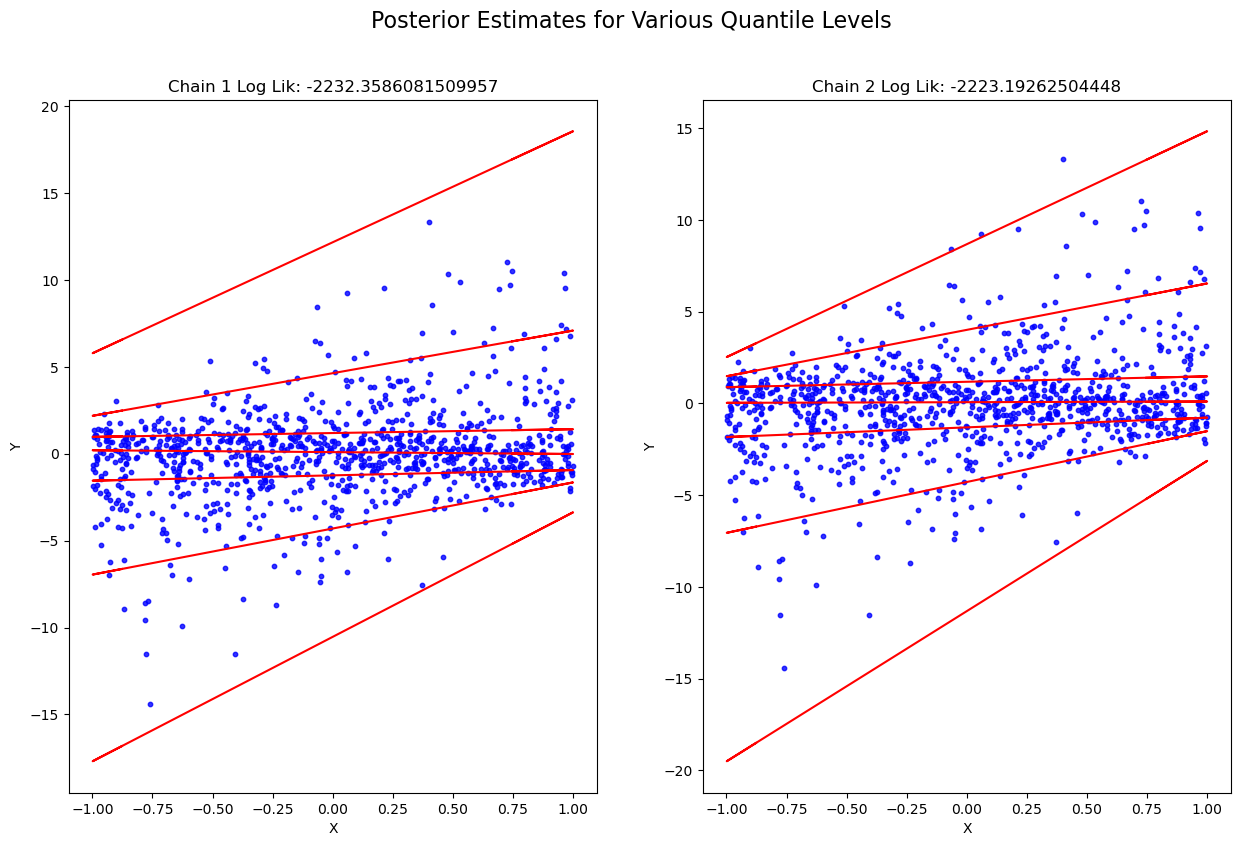

In [524]:
fig, ax = plt.subplots(1,2,figsize=(15,9))

for i in range(n_chains):
    ax[i].scatter(x_vals, y_vals_true, s=10, color='blue', alpha=0.8)

#sample_quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
sample_quantiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
#sample_quantiles = [0.5]

for sq in sample_quantiles:
    
    for i in range(n_chains):
        beta_0_samps, beta_1_samps = generate_beta_samples(tau_input=sq,
                                                      tau_grid=tau_grid_expanded,
                                                      w_approx_store=chain_outputs[i]['w'],
                                                      mu_store=chain_outputs[i]['mu'],
                                                      gamma_store=chain_outputs[i]['gamma'],
                                                      sigma_1_store=chain_outputs[i]['sigma_1'],
                                                      sigma_2_store=chain_outputs[i]['sigma_2'])

        y_pred_samples = np.array([b0 + b1*x_vals for b0,b1 in zip(beta_0_samps, beta_1_samps)])
        y_pred_samples = y_pred_samples[n_burn_in:]
        
        ax[i].plot(x_vals, y_pred_samples.mean(0), color='red')

for i in range(n_chains):    
    ax[i].title.set_text(f'Chain {i+1}'+' Log Lik: ' + str(log_scores[i]))
        
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')

#ax[0].set_ylim([-4,4])
#ax[1].set_ylim([-4,4])

ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')


fig.suptitle('Posterior Estimates for Various Quantile Levels', fontsize=16)

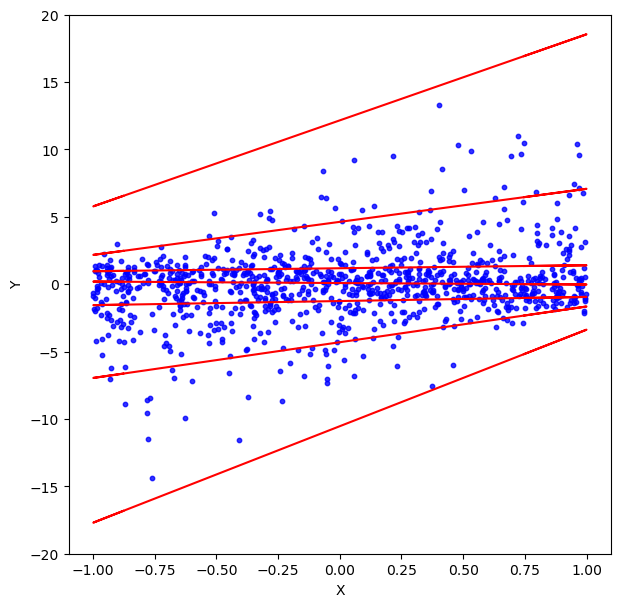

In [567]:
# Save image for plotting
fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(x_vals, y_vals_true, s=10, color='blue', alpha=0.8)

#sample_quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
sample_quantiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
#sample_quantiles = [0.5]

for sq in sample_quantiles:
    
    for i in range(1):
        beta_0_samps, beta_1_samps = generate_beta_samples(tau_input=sq,
                                                      tau_grid=tau_grid_expanded,
                                                      w_approx_store=chain_outputs[i]['w'],
                                                      mu_store=chain_outputs[i]['mu'],
                                                      gamma_store=chain_outputs[i]['gamma'],
                                                      sigma_1_store=chain_outputs[i]['sigma_1'],
                                                      sigma_2_store=chain_outputs[i]['sigma_2'])

        y_pred_samples = np.array([b0 + b1*x_vals for b0,b1 in zip(beta_0_samps, beta_1_samps)])
        y_pred_samples = y_pred_samples[n_burn_in:]
        
        ax.plot(x_vals, y_pred_samples.mean(0), color='red')
        
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_ylim([-20,20])

plt.savefig('Images/QR_model_est.png')


In [525]:
import arviz as az

## Plot Posterior GPs

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_46580/3947510274.py:82: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  w_approx_1_cis = az.hdi(w_approx_store_plot[:,0:L])
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_46580/3947510274.py:85: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  w_approx_2_cis = az.hdi(w_approx_store_plot[:,L:])
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_46580/3947510274.py:89: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  eta_1_cis = az.hdi(eta_1_collect)
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_46580/3947510274.py:92: FutureWarning: hdi currently interprets 2d data as 

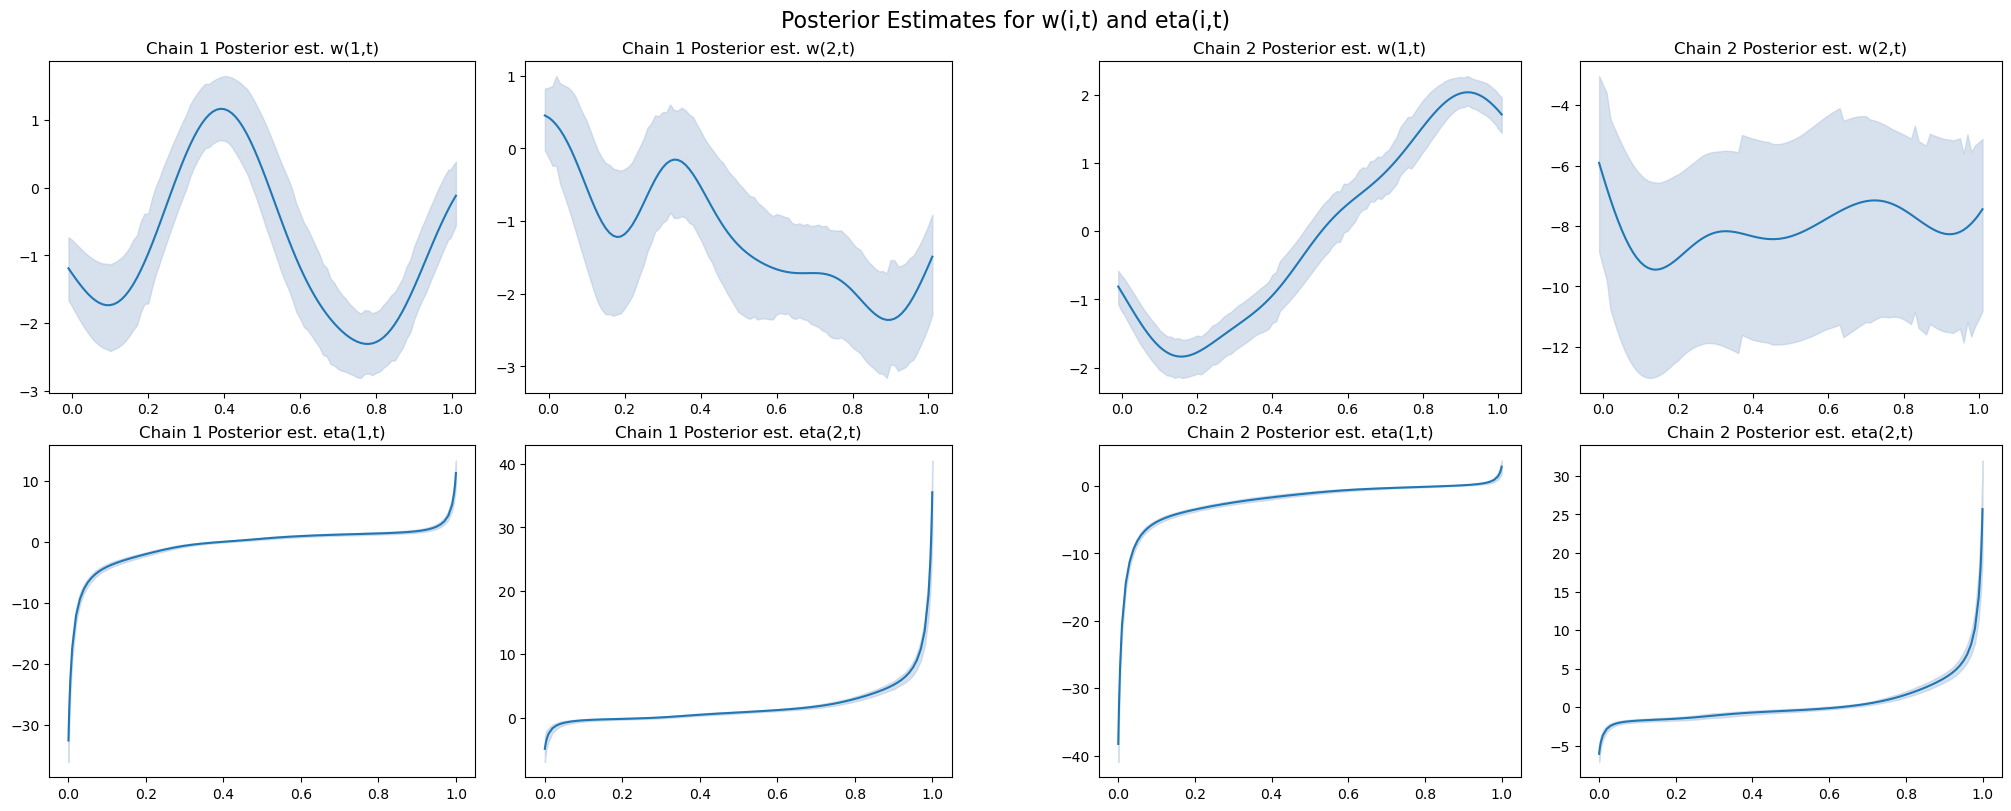

In [526]:
fig = plt.figure(layout='constrained', figsize=(20, 8))
subfigs = fig.subfigures(1, 2, wspace=0.1)

# Define left and right subfigure for chain 1 and 2
ax_left = subfigs[0].subplots(2,2)
ax_right = subfigs[1].subplots(2,2)

n_burn_in = 15000

#tau_grid_expanded = np.array([round(-0.01 + 0.01 * i,2) for i in range(103)])
#tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])

tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
tau_grid = np.concatenate([lower_seq, tau_grid, upper_seq])

tau_grid_expanded = np.concatenate([np.array([-0.01,0]),
                                    tau_grid,
                                    np.array([1,1.01])])


# Iterate over chains
for c in range(n_chains):
    
    mu_store=chain_outputs[c]['mu']
    gamma_store=chain_outputs[c]['gamma']
    sigma_1_store=chain_outputs[c]['sigma_1']
    sigma_2_store=chain_outputs[c]['sigma_2']
    
    w_approx_store = chain_outputs[c]['w']
    w_approx_store_plot = np.vstack(w_approx_store)[n_burn_in:,:]
    
    eta_1_collect = []
    eta_2_collect = []
    
    # Pass each function through the integrator to get xi
    for i in range(w_approx_store_plot.shape[0]):
        w_samp = w_approx_store_plot[i,:]
        
        L = int(w_samp.shape[0]/2)
        
        w1_samp = w_samp[0:L]
        w2_samp = w_samp[L:]

        mu_samp = mu_store[i+n_burn_in]
        gamma_samp = gamma_store[i+n_burn_in]
        sigma_1_samp = sigma_1_store[i+n_burn_in]
        sigma_2_samp = sigma_2_store[i+n_burn_in]
        
        
        # Get eta 1 and eta 2
        eta_1_samp = eta_function_i_vector(tau_input=tau_grid,
                                             w_vals=w1_samp,
                                             tau_grid=tau_grid_expanded,
                                             mean=0.0,
                                             sd=1.0,
                                             v=1.0,
                                             sigma=sigma_1_samp,
                                             dist='t')


        eta_2_samp = eta_function_i_vector(tau_input=tau_grid,
                                             w_vals=w2_samp,
                                             tau_grid=tau_grid_expanded,
                                             mean=0.0,
                                             sd=1.0,
                                             v=1.0,
                                             sigma=sigma_2_samp,
                                             dist='t')
        
        # Get resulting beta_0 and beta_1 samples
        beta_0_samp = mu_samp + (eta_1_samp + eta_2_samp)/2
        beta_1_samp = gamma_samp + (eta_2_samp - eta_1_samp)/2
        
        eta_1_collect.append(eta_1_samp)
        eta_2_collect.append(eta_2_samp)
        
    eta_1_collect = np.array(eta_1_collect)
    eta_2_collect = np.array(eta_2_collect)
        
    # Get w means and CIs
    w_approx_1_mean = w_approx_store_plot[:,0:L].mean(0)
    w_approx_1_cis = az.hdi(w_approx_store_plot[:,0:L])
    
    w_approx_2_mean = w_approx_store_plot[:,L:].mean(0)
    w_approx_2_cis = az.hdi(w_approx_store_plot[:,L:])
    
    # Get eta mean and CIs
    eta_1_mean = eta_1_collect.mean(0)
    eta_1_cis = az.hdi(eta_1_collect)
    
    eta_2_mean = eta_2_collect.mean(0)
    eta_2_cis = az.hdi(eta_2_collect)
    
    
    if c == 0:
        ax_left[0,0].plot(tau_grid_expanded, w_approx_1_mean, color='tab:blue')
        ax_left[0,0].fill_between(tau_grid_expanded, w_approx_1_cis[:,0],
                        w_approx_1_cis[:,1], color='lightsteelblue', alpha=.5)
        
        ax_left[0,1].plot(tau_grid_expanded, w_approx_2_mean, color='tab:blue')
        ax_left[0,1].fill_between(tau_grid_expanded, w_approx_2_cis[:,0],
                        w_approx_2_cis[:,1], color='lightsteelblue', alpha=.5)
        
        ax_left[0,0].title.set_text(f"Chain {c+1} Posterior est. w(1,t)")
        ax_left[0,1].title.set_text(f"Chain {c+1} Posterior est. w(2,t)")
        
        #ax_left[0,0].plot(tau_grid_expanded, w_approx_store_plot[:,0:103].T, c='tab:blue', alpha=0.1)
        #ax_left[0,1].plot(tau_grid_expanded, w_approx_store_plot[:,103:].T, c='tab:blue', alpha=0.1)
        
        #ax_left[1,0].plot(tau_grid, eta_1_collect.T, c='tab:blue', alpha=0.1)
        #ax_left[1,1].plot(tau_grid, eta_2_collect.T, c='tab:blue', alpha=0.1)
        
        ax_left[1,0].plot(tau_grid, eta_1_mean, color='tab:blue')
        ax_left[1,0].fill_between(tau_grid, eta_1_cis[:,0],
                        eta_1_cis[:,1], color='lightsteelblue', alpha=.5)
        
        ax_left[1,1].plot(tau_grid, eta_2_mean, color='tab:blue')
        ax_left[1,1].fill_between(tau_grid, eta_2_cis[:,0],
                        eta_2_cis[:,1], color='lightsteelblue', alpha=.5)
        
        ax_left[1,0].title.set_text(f"Chain {c+1} Posterior est. eta(1,t)")
        ax_left[1,1].title.set_text(f"Chain {c+1} Posterior est. eta(2,t)")
        
    
    else:
        ax_right[0,0].plot(tau_grid_expanded, w_approx_1_mean, color='tab:blue')
        ax_right[0,0].fill_between(tau_grid_expanded, w_approx_1_cis[:,0],
                        w_approx_1_cis[:,1], color='lightsteelblue', alpha=.5)
        
        ax_right[0,1].plot(tau_grid_expanded, w_approx_2_mean, color='tab:blue')
        ax_right[0,1].fill_between(tau_grid_expanded, w_approx_2_cis[:,0],
                        w_approx_2_cis[:,1], color='lightsteelblue', alpha=.5)
        
        ax_right[0,0].title.set_text(f"Chain {c+1} Posterior est. w(1,t)")
        ax_right[0,1].title.set_text(f"Chain {c+1} Posterior est. w(2,t)")
        
        #ax_right[0,0].plot(tau_grid_expanded, w_approx_store_plot[:,0:103].T, c='tab:blue', alpha=0.1)
        #ax_right[0,1].plot(tau_grid_expanded, w_approx_store_plot[:,103:].T, c='tab:blue', alpha=0.1)
        
        ax_right[1,0].plot(tau_grid, eta_1_mean, color='tab:blue')
        ax_right[1,0].fill_between(tau_grid, eta_1_cis[:,0],
                        eta_1_cis[:,1], color='lightsteelblue', alpha=.5)
        
        ax_right[1,1].plot(tau_grid, eta_2_mean, color='tab:blue')
        ax_right[1,1].fill_between(tau_grid, eta_2_cis[:,0],
                        eta_2_cis[:,1], color='lightsteelblue', alpha=.5)
        
        ax_right[1,0].title.set_text(f"Chain {c+1} Posterior est. eta(1,t)")
        ax_right[1,1].title.set_text(f"Chain {c+1} Posterior est. eta(2,t)")
        
        
fig.suptitle('Posterior Estimates for w(i,t) and eta(i,t)', fontsize=16)
plt.show()



## Plot Posterior Betas

In [527]:
#tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])

tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
tau_grid = np.concatenate([lower_seq, tau_grid, upper_seq])


tau_grid_expanded = np.concatenate([np.array([-0.01,0]),
                                    tau_grid,
                                    np.array([1,1.01])])

tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])


chain_store = []
for i in range(n_chains):
    b0_val_samples = []
    b1_val_samples = []
    for sq in tau_grid:
        beta_0_samps, beta_1_samps = generate_beta_samples(tau_input=sq,
                                                      tau_grid=tau_grid_expanded,
                                                      w_approx_store=chain_outputs[i]['w'],
                                                      mu_store=chain_outputs[i]['mu'],
                                                      gamma_store=chain_outputs[i]['gamma'],
                                                      sigma_1_store=chain_outputs[i]['sigma_1'],
                                                      sigma_2_store=chain_outputs[i]['sigma_2'])
    
        b0_val_samples.append(beta_0_samps)
        b1_val_samples.append(beta_1_samps)
    
    b0_val_samples = np.array(b0_val_samples)
    b1_val_samples = np.array(b1_val_samples)
    
    chain_store.append([b0_val_samples, b1_val_samples])

In [528]:
fig, ax = plt.subplots(2,2,figsize=(10,5))

# Get true values
beta_0_true = test_beta_0(tau_grid)
beta_1_true = test_beta_1(tau_grid)

for c in range(n_chains):

    b0_samples, b1_samples = chain_store[c]
    
    # Get b0 b1 means and CIs
    b0_mean = b0_samples.T[n_burn_in:].mean(0)
    b0_cis = az.hdi(b0_samples.T[n_burn_in:])
    
    b1_mean = b1_samples.T[n_burn_in:].mean(0)
    b1_cis = az.hdi(b1_samples.T[n_burn_in:])
    
    
    # Plot values
    ax[0,c].plot(tau_grid, b0_mean, color='tab:blue')
    ax[0,c].fill_between(tau_grid, b0_cis[:,0],
                    b0_cis[:,1], color='lightsteelblue', alpha=.5)
    
    ax[1,c].plot(tau_grid, b1_mean, color='tab:blue')
    ax[1,c].fill_between(tau_grid, b1_cis[:,0],
                    b1_cis[:,1], color='lightsteelblue', alpha=.5)
    

    ax[0,c].plot(tau_grid,beta_0_true,c = 'tab:red',alpha = 1)
    ax[1,c].plot(tau_grid,beta_1_true,c = 'tab:red',alpha = 1)
    
    ax[0,c].title.set_text(f"Chain {c+1} Posterior est. b0")
    ax[1,c].title.set_text(f"Chain {c+1} Posterior est. b1")

fig.suptitle('Posterior Estimates for b0 and b1', fontsize=16)

plt.tight_layout()
plt.show()

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_46580/345786256.py:13: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  b0_cis = az.hdi(b0_samples.T[n_burn_in:])
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_46580/345786256.py:16: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  b1_cis = az.hdi(b1_samples.T[n_burn_in:])


/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_46580/3488693749.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  b0_comb_cis = az.hdi(b0_samples_comb.T)
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_46580/3488693749.py:13: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  b1_comb_cis = az.hdi(b1_samples_comb.T)


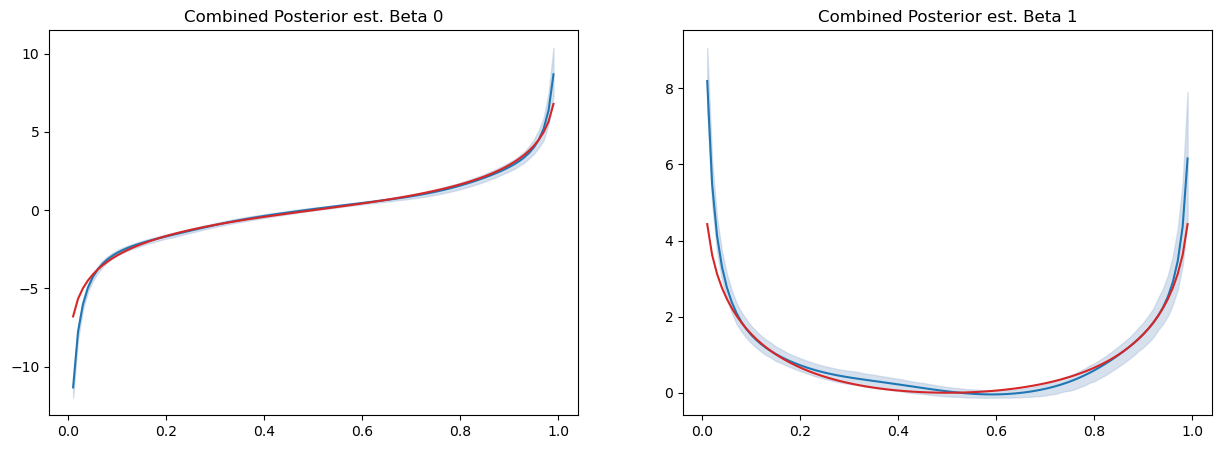

In [564]:
# Get combined error
b0_samples_comb = np.hstack([chain_store[0][0][:,n_burn_in:],
                         chain_store[1][0][:,n_burn_in:]])

b1_samples_comb = np.hstack([chain_store[0][1][:,n_burn_in:],
                         chain_store[1][1][:,n_burn_in:]])

# Get b0 b1 means and CIs
b0_comb_mean = b0_samples_comb.T.mean(0)
b0_comb_cis = az.hdi(b0_samples_comb.T)

b1_comb_mean = b1_samples_comb.T.mean(0)
b1_comb_cis = az.hdi(b1_samples_comb.T)

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(tau_grid, b0_mean, color='tab:blue')
ax[0].fill_between(tau_grid, b0_cis[:,0],
                b0_cis[:,1], color='lightsteelblue', alpha=.5)

ax[1].plot(tau_grid, b1_mean, color='tab:blue')
ax[1].fill_between(tau_grid, b1_cis[:,0],
                b1_cis[:,1], color='lightsteelblue', alpha=.5)


ax[0].plot(tau_grid,beta_0_true,c = 'tab:red',alpha = 1)
ax[1].plot(tau_grid,beta_1_true,c = 'tab:red',alpha = 1)

ax[0].title.set_text(f"Combined Posterior est. Beta 0")
ax[1].title.set_text(f"Combined Posterior est. Beta 1")

plt.savefig('Images/QR_beta_est.png')

In [530]:
import pandas as pd
output_frame = pd.DataFrame({'B0_mean': b0_comb_mean,
              'B0_lo': b0_comb_cis[:,0],
              'B0_hi': b0_comb_cis[:,1],
              'B1_mean': b1_comb_mean,
              'B1_lo': b1_comb_cis[:,0],
              'B1_hi': b1_comb_cis[:,1],
              'B0_true': beta_0_true,
              'B1_true': beta_1_true}
              )

Some processing of Surya Experiment results

In [568]:
all_run_store = []
for e_id in range(1,101):

    fp = f'Exp Results/QR Surya Dataset 2/Run_{e_id}'
    df_fp = fp+'/predictions.csv'

    run_df = pd.read_csv(df_fp)

    run_df['tau'] = tau_grid

    run_df['B0_error'] = np.abs(run_df['B0_mean']-run_df['B0_true'])
    run_df['B1_error'] = np.abs(run_df['B1_mean']-run_df['B1_true'])
    run_df['B0_covered'] = (run_df['B0_lo'] < run_df['B0_true']) & (run_df['B0_hi'] > run_df['B0_true'])
    run_df['B1_covered'] = (run_df['B1_lo'] < run_df['B1_true']) & (run_df['B1_hi'] > run_df['B1_true'])
    run_df['Run_ID'] = e_id
    all_run_store.append(run_df)

In [569]:
all_run_store = pd.concat(all_run_store)

all_run_store = all_run_store[['tau','B0_error','B1_error','B0_covered','B1_covered']].groupby(
    'tau',as_index=False).mean()

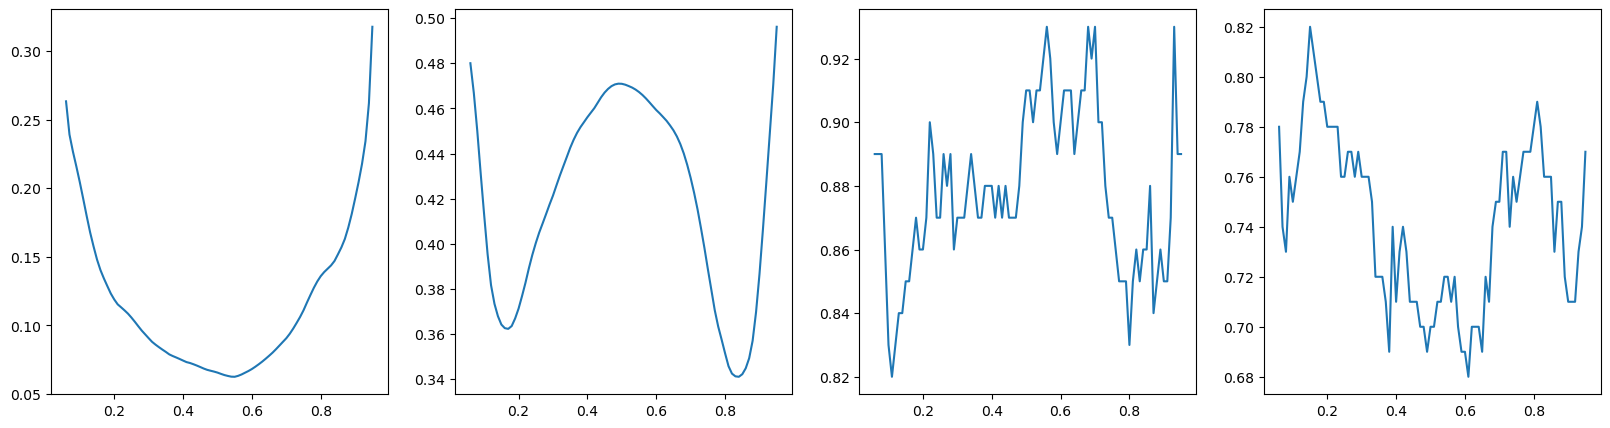

In [570]:
fig,ax = plt.subplots(1,4, figsize=(20,5))

all_run_store_plot = all_run_store.iloc[5:95,:]

ax[0].plot(all_run_store_plot['tau'], all_run_store_plot['B0_error'])
ax[1].plot(all_run_store_plot['tau'], all_run_store_plot['B1_error'])
ax[2].plot(all_run_store_plot['tau'], all_run_store_plot['B0_covered'])
ax[3].plot(all_run_store_plot['tau'], all_run_store_plot['B1_covered'])


In [554]:
all_run_store_plot

tau  B0_error  B1_error  B0_covered  B1_covered
5   0.06  0.257683  0.418672        0.85        0.78
6   0.07  0.241253  0.411757        0.83        0.75
7   0.08  0.230000  0.406283        0.79        0.71
8   0.09  0.217516  0.396773        0.78        0.69
9   0.10  0.203310  0.386841        0.78        0.66
..   ...       ...       ...         ...         ...
90  0.91  0.209375  0.339374        0.75        0.69
91  0.92  0.230648  0.360004        0.72        0.71
92  0.93  0.254509  0.382405        0.70        0.73
93  0.94  0.287765  0.407593        0.75        0.73
94  0.95  0.338664  0.435205        0.77        0.77

[90 rows x 5 columns]

In [557]:
np.argmax(log_scores)

1